In [1]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

from contextlib import contextmanager
from time import time
from tqdm import tqdm
import lightgbm as lgbm
import category_encoders as ce

from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# Data preparation

In [2]:
data0 = pd.read_csv("../input/avacado-price-prediction/Avocado.csv")
data0[0:5].T

,0,1,2,3,4
Unnamed: 0,0,1,2,3,4
Date,2015-12-27,2015-12-20,2015-12-13,2015-12-06,2015-11-29
AveragePrice,1.33,1.35,0.93,1.08,1.28
Total Volume,64236.62,54876.98,118220.22,78992.15,51039.6
4046,1036.74,674.28,794.7,1132.0,941.48
4225,54454.85,44638.81,109149.67,71976.41,43838.39
4770,48.16,58.33,130.5,72.58,75.78
Total Bags,8696.87,9505.56,8145.35,5811.16,6183.95
Small Bags,8603.62,9408.07,8042.21,5677.4,5986.26
Large Bags,93.25,97.49,103.14,133.76,197.69


In [3]:
print(data0['type'].value_counts())
print()
print(data0['year'].value_counts())
print()
print(data0['region'].value_counts())

conventional    9126
organic         9123
Name: type, dtype: int64

2017    5722
2016    5616
2015    5615
2018    1296
Name: year, dtype: int64

Houston                338
MiamiFtLauderdale      338
Southeast              338
NewOrleansMobile       338
Indianapolis           338
GrandRapids            338
California             338
Louisville             338
SanDiego               338
Boise                  338
Albany                 338
Columbus               338
Orlando                338
CincinnatiDayton       338
SouthCentral           338
Portland               338
Roanoke                338
LosAngeles             338
Denver                 338
SouthCarolina          338
NorthernNewEngland     338
GreatLakes             338
RichmondNorfolk        338
Charlotte              338
HarrisburgScranton     338
Jacksonville           338
Detroit                338
Syracuse               338
HartfordSpringfield    338
StLouis                338
TotalUS                338
Boston           

In [4]:
data0=data0.drop(['Unnamed: 0','Date'],axis=1)

In [5]:
data0.columns.to_list()

['AveragePrice',
 'Total Volume',
 '4046',
 '4225',
 '4770',
 'Total Bags',
 'Small Bags',
 'Large Bags',
 'XLarge Bags',
 'type',
 'year',
 'region']

In [6]:
df=data0
from sklearn.preprocessing import LabelEncoder
for c in df.columns:
    if df[c].dtype=='object': 
        df[c] = df[c].fillna('N')
        lbl = LabelEncoder()
        lbl.fit(list(df[c].values))
        df[c] = lbl.transform(df[c].values)

In [7]:
data1=df
data1[0:5].T

,0,1,2,3,4
AveragePrice,1.33,1.35,0.93,1.08,1.28
Total Volume,64236.62,54876.98,118220.22,78992.15,51039.60
4046,1036.74,674.28,794.70,1132.00,941.48
4225,54454.85,44638.81,109149.67,71976.41,43838.39
4770,48.16,58.33,130.50,72.58,75.78
Total Bags,8696.87,9505.56,8145.35,5811.16,6183.95
Small Bags,8603.62,9408.07,8042.21,5677.40,5986.26
Large Bags,93.25,97.49,103.14,133.76,197.69
XLarge Bags,0.00,0.00,0.00,0.00,0.00
type,0.00,0.00,0.00,0.00,0.00


In [8]:
data1.columns

Index(['AveragePrice', 'Total Volume', '4046', '4225', '4770', 'Total Bags',
       'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'year', 'region'],
      dtype='object')

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


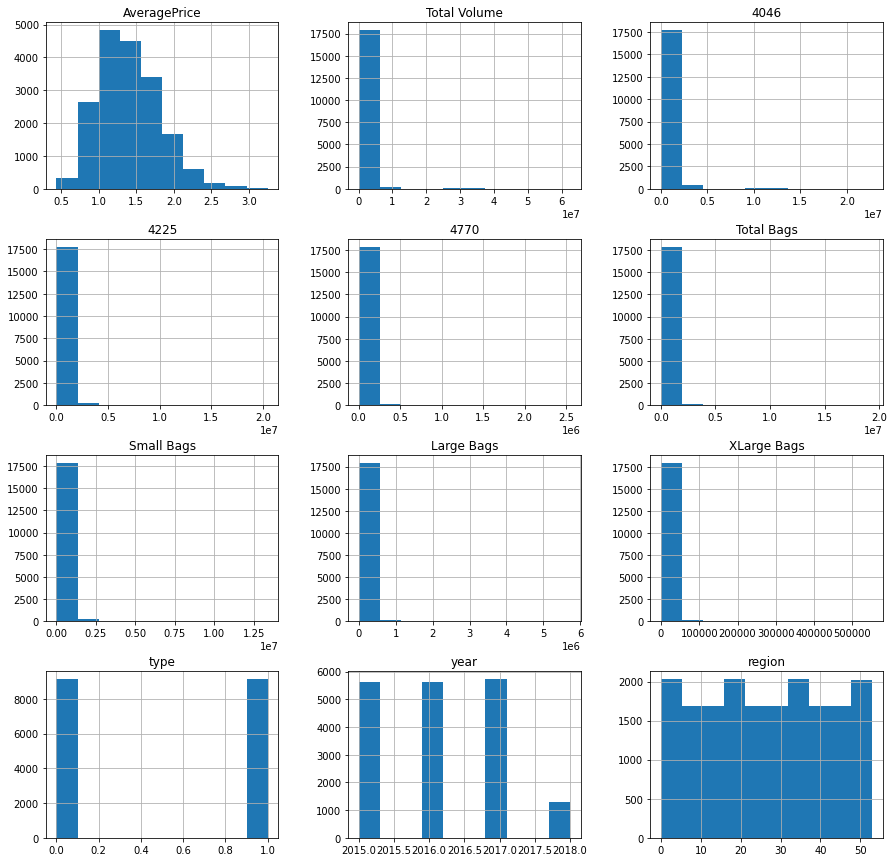

In [9]:
data1.iloc[:,:].hist(figsize=(15,15))
plt.show()

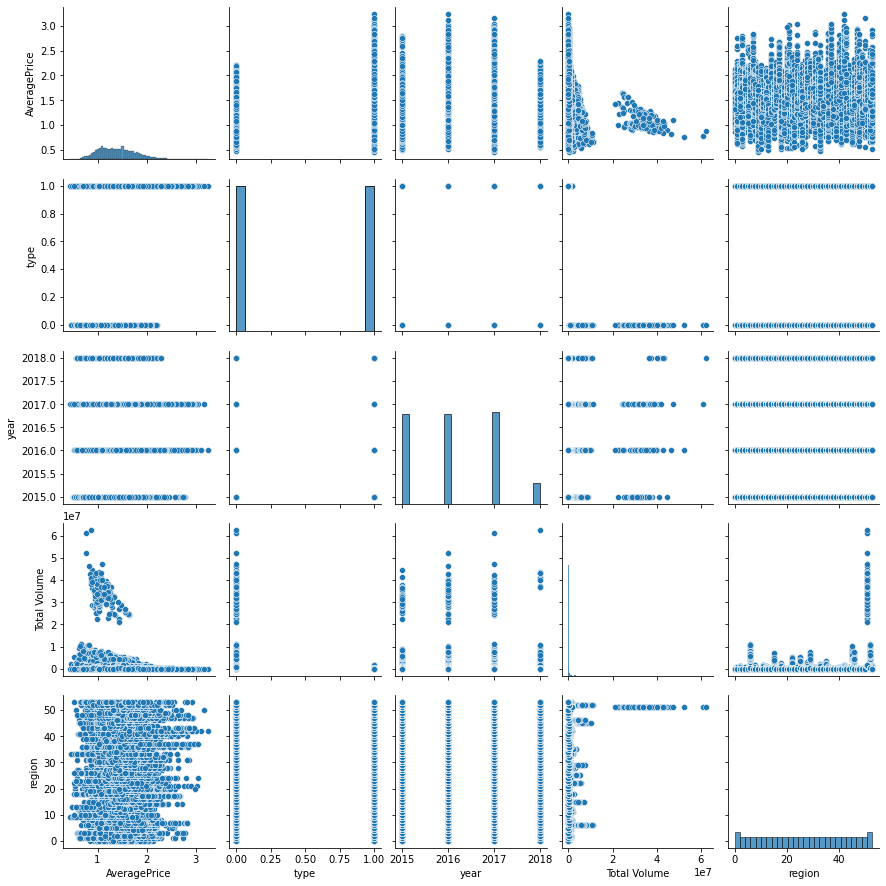

In [10]:
datap=data1[['AveragePrice', 'type','year','Total Volume','region']]
sns.pairplot(datap)
plt.show()

# Target setting

In [11]:
target=['AveragePrice']
dataY=data1[target]
dataX=data1.drop(target,axis=1)

In [12]:
print(dataY[0:5].T)
print()
print(dataX[0:5].T)

                 0     1     2     3     4
AveragePrice  1.33  1.35  0.93  1.08  1.28

                     0         1          2         3         4
Total Volume  64236.62  54876.98  118220.22  78992.15  51039.60
4046           1036.74    674.28     794.70   1132.00    941.48
4225          54454.85  44638.81  109149.67  71976.41  43838.39
4770             48.16     58.33     130.50     72.58     75.78
Total Bags     8696.87   9505.56    8145.35   5811.16   6183.95
Small Bags     8603.62   9408.07    8042.21   5677.40   5986.26
Large Bags       93.25     97.49     103.14    133.76    197.69
XLarge Bags       0.00      0.00       0.00      0.00      0.00
type              0.00      0.00       0.00      0.00      0.00
year           2015.00   2015.00    2015.00   2015.00   2015.00
region            0.00      0.00       0.00      0.00      0.00


In [13]:
n=len(dataX)
N=[]
for i in range(n):
    N+=[i]
random.shuffle(N)

In [14]:
trainX=dataX.loc[N[0:(n//4)*3]]
trainY=dataY.loc[N[0:(n//4)*3]]
testX=dataX.loc[N[(n//4)*3:]]
testY=dataY.loc[N[(n//4)*3:]]

In [15]:
df_columns = list(dataX.columns)
print(df_columns)

['Total Volume', '4046', '4225', '4770', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'year', 'region']


In [16]:
def create_numeric_feature(input_df):
    use_columns = df_columns 
    return input_df[use_columns].copy()

In [17]:
from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [18]:
from tqdm import tqdm

def to_feature(input_df):

    processors = [
        create_numeric_feature,
    ]
    
    out_df = pd.DataFrame()
    
    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='create' + func.__name__ + ' '):
            _df = func(input_df)

        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [19]:
train_feat_df = to_feature(trainX)
test_feat_df = to_feature(testX)

100%|██████████| 1/1 [00:00<00:00, 503.76it/s]

createcreate_numeric_feature  0.004[s]
createcreate_numeric_feature  0.001[s]


# Model

In [20]:
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error

def fit_lgbm(X, y, cv, 
             params: dict=None, 
             verbose: int=50):

    if params is None:
        params = {}

    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)
        
        with Timer(prefix='fit fold={} '.format(i)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=100,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        print(f'Fold {i} RMSLE: {mean_squared_error(y_valid, pred_i) ** .5:.4f}')
        print()

    score = mean_squared_error(y, oof_pred) ** .5
    print('-' * 50)
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

In [21]:
params = {
    'objective': 'rmse', 
    'learning_rate': .1,
    'reg_lambda': 1.,
    'reg_alpha': .1,
    'max_depth': 5, 
    'n_estimators': 10000, 
    'colsample_bytree': .5, 
    'min_child_samples': 10,
    'subsample_freq': 3,
    'subsample': .9,
    'importance_type': 'gain', 
    'random_state': 71,
    'num_leaves': 62
}

In [22]:
y = trainY
print(y.shape)
print(type(y))

(13686, 1)
<class 'pandas.core.frame.DataFrame'>


In [23]:
ydf=pd.DataFrame(y)
ydf

,AveragePrice
17545,1.29
486,1.05
10219,1.99
15907,1.74
11815,1.53
...,...
7144,1.55
3273,1.11
10169,1.76
11526,1.73


Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.167267
[1000]	valid_0's rmse: 0.160483
[1500]	valid_0's rmse: 0.157871
[2000]	valid_0's rmse: 0.157102
Early stopping, best iteration is:
[2286]	valid_0's rmse: 0.156838
fit fold=0  3.709[s]
Fold 0 RMSLE: 0.1568

Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.164593
[1000]	valid_0's rmse: 0.158161
[1500]	valid_0's rmse: 0.156774
Early stopping, best iteration is:
[1787]	valid_0's rmse: 0.156512
fit fold=1  2.536[s]
Fold 1 RMSLE: 0.1565

Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.159882
[1000]	valid_0's rmse: 0.153624
[1500]	valid_0's rmse: 0.151599
Early stopping, best iteration is:
[1697]	valid_0's rmse: 0.151194
fit fold=2  2.401[s]
Fold 2 RMSLE: 0.1512

Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.171451
[1000]	valid_0's rmse: 0.165551
[1500]	valid_0's rmse: 0.163986
[2000]	val

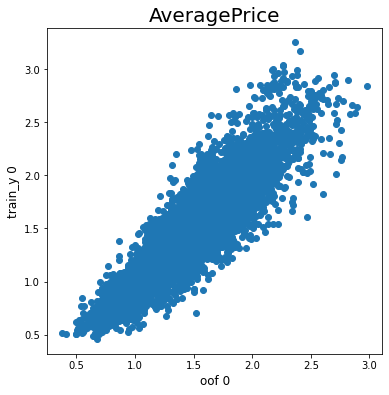

In [24]:
from sklearn.model_selection import KFold

for i in range(1):
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)
    
    fig,ax = plt.subplots(figsize=(6,6))
    ax.set_title(target[i],fontsize=20)
    ax.set_xlabel('oof '+str(i),fontsize=12)
    ax.set_ylabel('train_y '+str(i),fontsize=12)
    ax.scatter(oof,y)


In [25]:
print(target)

['AveragePrice']


# Visualize Importance

In [26]:
def visualize_importance(models, feat_train_df):

    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    
    ax.tick_params(axis='x', rotation=0)
    #ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    
    return fig,ax

#fig, ax = visualize_importance(models, train_feat_df)

Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.167267
[1000]	valid_0's rmse: 0.160483
[1500]	valid_0's rmse: 0.157871
[2000]	valid_0's rmse: 0.157102
Early stopping, best iteration is:
[2286]	valid_0's rmse: 0.156838
fit fold=0  4.401[s]
Fold 0 RMSLE: 0.1568

Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.164593
[1000]	valid_0's rmse: 0.158161
[1500]	valid_0's rmse: 0.156774
Early stopping, best iteration is:
[1787]	valid_0's rmse: 0.156512
fit fold=1  3.051[s]
Fold 1 RMSLE: 0.1565

Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.159882
[1000]	valid_0's rmse: 0.153624
[1500]	valid_0's rmse: 0.151599
Early stopping, best iteration is:
[1697]	valid_0's rmse: 0.151194
fit fold=2  2.822[s]
Fold 2 RMSLE: 0.1512

Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.171451
[1000]	valid_0's rmse: 0.165551
[1500]	valid_0's rmse: 0.163986
[2000]	val

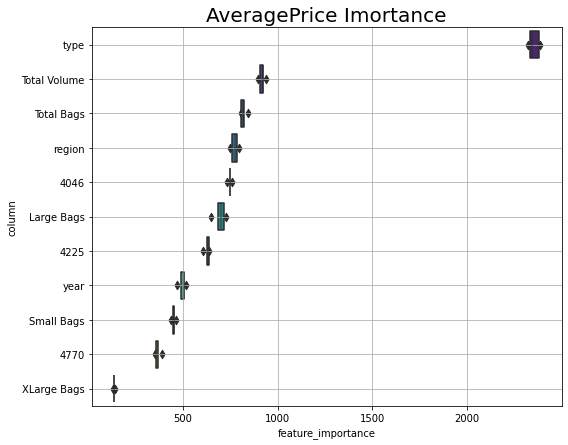

In [27]:
for i in range(1):
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)
    fig, ax = visualize_importance(models, train_feat_df)
    ax.set_title(target[i]+' Imortance',fontsize=20)


### For 'AveragePrice', 'type' is the most important factor. 

In [28]:
pred0 = np.array([model.predict(test_feat_df.values) for model in models])
PRED = pred0[4]
PRED[0:5]

array([1.38001002, 1.6641815 , 0.79506239, 1.22497236, 1.58113003])

In [29]:
ans=[]
for i in range(len(testY)):
    ans+=[testY.iloc[i,0]]
ANS=np.array(ans)
ANS[0:5]

array([1.35, 1.57, 0.81, 2.71, 1.66])

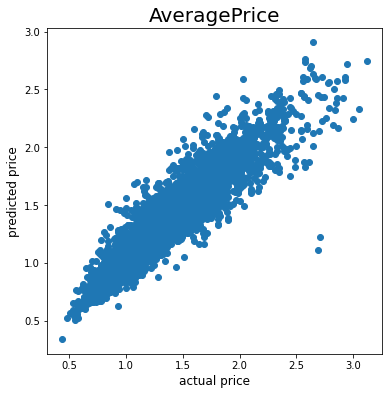

In [30]:
fig,ax = plt.subplots(figsize=(6,6))
ax.set_title(target[0],fontsize=20)
ax.set_xlabel('actual price',fontsize=12)
ax.set_ylabel('predicted price',fontsize=12)
ax.scatter(ANS,PRED)

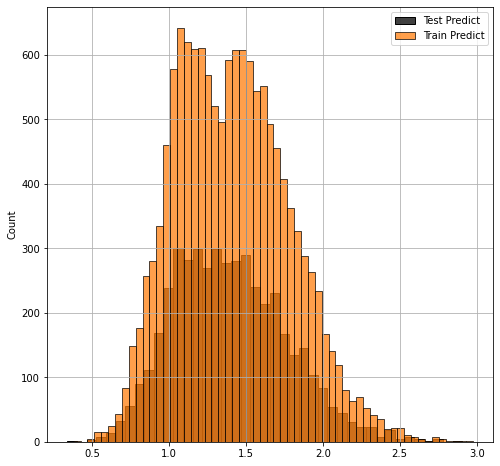

In [31]:
fig, ax = plt.subplots(figsize=(8,8))
sns.histplot(PRED, label='Test Predict', ax=ax, color='black')
sns.histplot(oof, label='Train Predict', ax=ax, color='C1')
ax.legend()
ax.grid()